This notebook compares the predicted and actual net precipitation, and also trains a logistic regression model to predict when P-E will exceed a certain value.

The main conclusions are

1. the net precipitation differs when computed via $Q_1$ (NetPrecQ1) or $P-E$ (NetPrec). In particular the thresholded of the former are much too noisy
2. Logistic regressions trained with net precip from NetPrecQ1 closely resemble NetPrec
3. The NN does not correctly predict where NetPrec < -5 mm /d
4. The NN under-predicts NetPrec, especially when NetPrec is large.

In [1]:
import torch
from uwnet.thermo import integrate_q2



import gnl

gnl.colorblind()

from src.data import open_data
from uwnet.thermo import lhf_to_evap, compute_apparent_source, integrate_q2, net_precipitation_from_training, \
    net_precipitation_from_prec_evap
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression


import xarray as xr


class Sampler:
    """Defines what a `sample` of an xarray dataset for supervised learning"""
    def __init__(self, input_variables, output_variables, feature_dims, sample_dims):
        self.inputs = input_variables
        self.outputs = output_variables
        self.feature_dims = feature_dims
        self.sample_dims = sample_dims

    def to_input_data_matrix(self, data):
        ds = data.stack(samples=self.sample_dims)
        x = ds[self.inputs].to_stacked_array('feature', self.feature_dims)
        valid_feats =[feature_valid(var, z) for (var, z) in x.feature.values]
        return x[:, valid_feats]
    
    def to_output_vector(self, data):
        ds = data.stack(sample=self.sample_dims)[self.outputs]
        return ds
    
    def from_output_vector(self, data, samples):
        return xr.DataArray(data, dims='samples', coords={'samples': samples}).unstack('samples')
    
    def prepare_data(self, data):
        return self.to_input_data_matrix(data), self.to_output_vector(data)
    
    
class SklearnWrapper:
    def __init__(self, sampler, model):
        self.sampler = sampler
        self.model = model
    
    def predict(self, data):
        x = self.sampler.to_input_data_matrix(data)
        y = self.model.predict(x)
        return self.sampler.from_output_vector(y, x.samples)
            
    def fit(self, data):
        x, y = self.sampler.prepare_data(data)
        [x_train, y_train], [x_test, y_test] = split_train_test(x, y)
        self.model.fit(x_train, y_train)
        
        print("Training score", self.model.score(x_train, y_train))
        print("Testing score", self.model.score(x_test, y_test))
        return self

def feature_valid(var, z):
    if var == 'QT':
        if z < 10000:
            return True
        else:
            return False
    if var == 'SLI':
        if z < 10000:
            return True
        else:
            return False
    return True


def split_train_test(x, y):

    nsample = 10000
    
    valid_feats =[feature_valid(var, z) for (var, z) in x.feature.values]
    
    inds = np.random.choice(x.shape[0], nsample)
    inds.sort()
    x_train, y_train = x[inds, valid_feats].values, y[inds].values

    inds = np.random.choice(x.shape[0], nsample)
    inds.sort()
    x_test, y_test = x[inds, valid_feats].values, y[inds].values
    
    return [x_train, y_train], [x_test, y_test]


def get_nn_prediction(ds, path="../models/277/3.pkl"):
    model = torch.load(path)
    ds_in = ds.drop('precip')
    out= model.predict(ds_in)
    nn = -integrate_q2(out['QT'], ds.layer_mass) 
    return nn


ds = open_data('training').isel(time=slice(0, 40))
pme = net_precipitation_from_training(ds)
ds['precip'] = pme < - 5

samples = ['y', 'x', 'time']
inputs = ['SST', 'SOLIN', 'QT', 'SLI']
feature_dims = ['z']

sampler = Sampler(inputs, 'precip', feature_dims, samples)
skmodel = LogisticRegression()
model = SklearnWrapper(sampler, skmodel)
model.fit(ds);

/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training score 0.7686
Testing score 0.7738


# plot predictions

In [2]:
out_xr = model.predict(ds)
truth = ds.precip.unstack()
truth_accurate = net_precipitation_from_prec_evap(ds) < -5
nn_pred = get_nn_prediction(ds)
nn_pred_thresh = nn_pred < -5

/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.container.ParameterDict' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/noah/anaconda/envs/uwnet/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve th

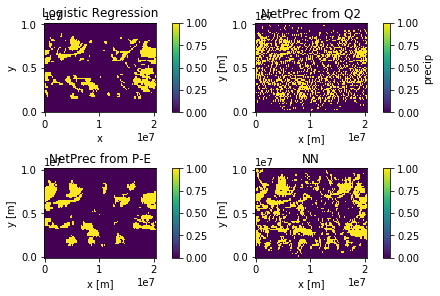

In [3]:
fig, axs = plt.subplots(2, 2, constrained_layout=True)
axs = axs.ravel()
i = 0

out_xr.isel(time=0).plot(ax=axs[i])
axs[i].set_title('Logistic Regression')
i+=1

truth.isel(time=0).plot(ax=axs[i])
axs[i].set_title('NetPrec from Q2')
i+=1

truth_accurate.isel(time=0).plot(ax=axs[i])
axs[i].set_title('NetPrec from P-E')
i+=1

nn_pred_thresh.isel(time=0).plot(ax=axs[i])
axs[i].set_title('NN')
i+=1

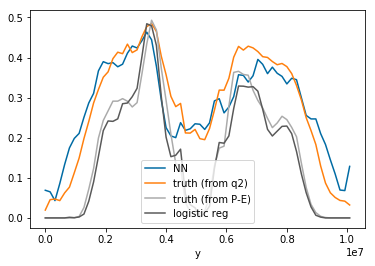

In [4]:
mean_dims = ['x', 'time']

nn_pred_thresh.mean(mean_dims).plot(label='NN')
truth.mean(mean_dims).plot(label='truth (from q2)')
truth_accurate.mean(mean_dims).plot(label='truth (from P-E)')
out_xr.mean(mean_dims).plot(label='logistic reg')
plt.legend()

It looks like the NN produces a dramatically wrong pattern of evap for Evap < -5.

Which threshold does the NN do the worst for?

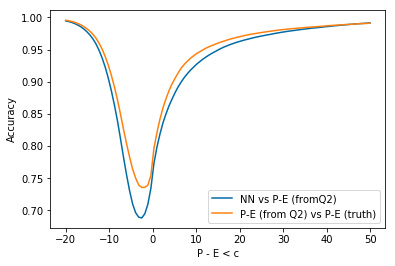

In [5]:
def error_by_treshold(x, y):
    c = np.linspace(-20, 50, 101)
    b = []
    
    for cc in c:
        ans = ((x < cc) == (y < cc)).mean()
        b.append(ans)
    return c, np.array(b)


def plot_threshold_error(x, y, **kwargs):
    c, accuracy = error_by_treshold(x, y)
    plt.plot(c, accuracy, **kwargs)
    plt.xlabel('P - E < c')
    plt.ylabel('Accuracy')
    
plot_threshold_error(nn_pred, net_precipitation_from_training(ds), label='NN vs P-E (fromQ2)')
plot_threshold_error(
    net_precipitation_from_training(ds), net_precipitation_from_prec_evap(ds),
    label='P-E (from Q2) vs P-E (truth)')
plt.legend()

It does worst at thresholding P -E < -4 or so.

# Compare predicted and actual P-E

In [6]:
import pandas as pd

# Compare predicted and actual P-E
bins = np.linspace(-20, 40, 40)
data_c = xr.Dataset({'nn': nn_pred, 'pme': net_precipitation_from_prec_evap(ds)}).to_dataframe()


# compute joint histogram
counts = np.histogram(data_c.pme, bins)[0]
counts = np.ma.masked_values(counts, 0)
Cmat = np.histogram2d(data_c.nn, data_c.pme, [bins, bins])[0]/counts
prob_less_than = Cmat.cumsum(0)

This plot shows the probability of a truth exceeding predicted value of net precip. The black line has a slope of one, and should lie on top of the 50% countour. This indicates that net precip is underestimated by the NN (especially for the postive precip points.)

Text(0.5, 1.0, 'P(Pred NetPrec < c | Truth)')

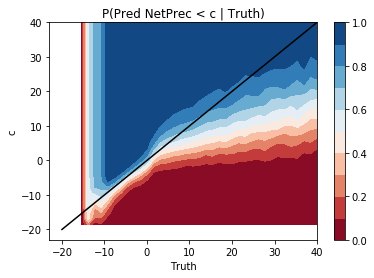

In [7]:
plt.contourf(bins[1:], bins[1:], prob_less_than, vmin=0, vmax=1, levels=10, cmap='RdBu')
plt.plot(bins, bins, color='k')
plt.xlabel("Truth")
plt.ylabel("c")
plt.colorbar()
plt.title("P(Pred NetPrec < c | Truth)")